## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Padded BG data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [81]:
data_dir = Path('data_02')
data_orig = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid'

In [7]:
NB_NUM='03_20'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: ad026345, DATE: 20191118


In [9]:
DATE = '20191118'
UID = 'a18f1438'

In [10]:
SUB_NUM='20'

In [11]:
#wrap or reflect
border='reflect'
#padded or padded_bg
pad_type='padded'
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
len(df_all)

22553

In [17]:
df_valid=df_all.loc[df_all['verified'] == True]

In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
assert len(df_test)==7325

In [21]:
df_valid.loc[df_valid['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [22]:
len(df_valid)

14870

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [23]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [24]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [25]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [26]:
#to check what params object has
#dir(data)

In [27]:
data.label_list

LabelLists;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256

In [28]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

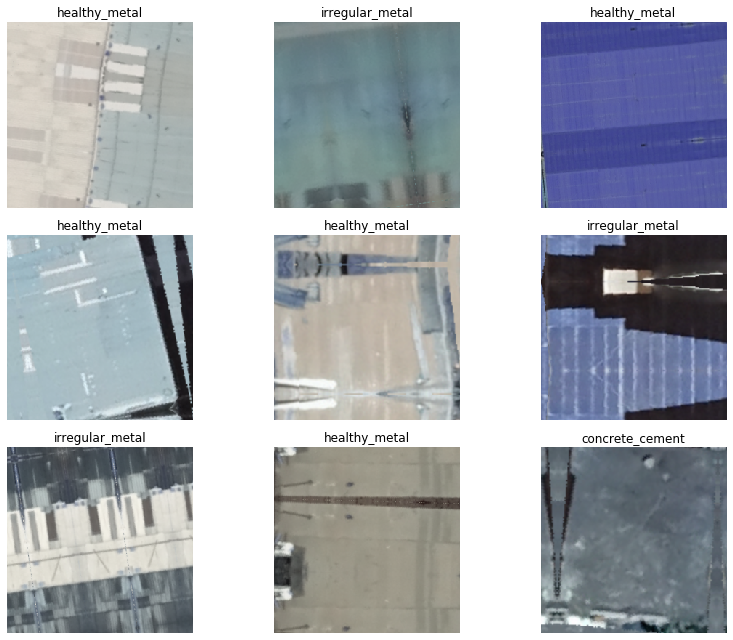

In [29]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [30]:
arch = models.resnet50
arch_name = 'rn50'

In [31]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [32]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


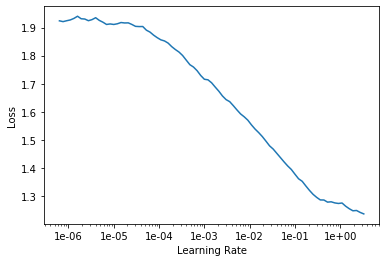

In [34]:
learn.recorder.plot()

Then we can fit the head of our network.

In [35]:
lr = 2e-3

In [36]:
#learn.fit_one_cycle(5, slice(lr))

In [37]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn50-03_20-cv_reflect_101_valid-20191118-a18f1438


In [38]:
#learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [39]:
#learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [40]:
#learn.fit_one_cycle(5, slice(lr))

In [41]:
#learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [42]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 204),
 ('healthy_metal', 'irregular_metal', 130),
 ('incomplete', 'irregular_metal', 58),
 ('incomplete', 'concrete_cement', 28),
 ('concrete_cement', 'healthy_metal', 25),
 ('healthy_metal', 'concrete_cement', 22),
 ('concrete_cement', 'irregular_metal', 19),
 ('irregular_metal', 'concrete_cement', 16),
 ('other', 'healthy_metal', 15),
 ('concrete_cement', 'incomplete', 13),
 ('irregular_metal', 'incomplete', 11),
 ('incomplete', 'healthy_metal', 10),
 ('other', 'irregular_metal', 8),
 ('irregular_metal', 'other', 5),
 ('healthy_metal', 'incomplete', 4),
 ('healthy_metal', 'other', 2)]

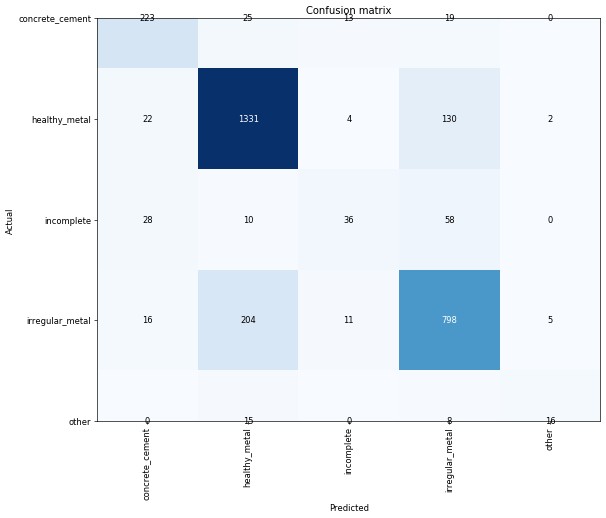

In [44]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [45]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


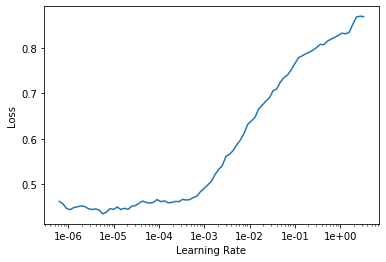

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(2e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.473896,0.530603,0.195696,01:02
1,0.473492,0.517316,0.190652,01:02
2,0.444828,0.516157,0.190652,01:00
3,0.398551,0.509728,0.189980,01:01
4,0.370024,0.507769,0.184936,01:01


In [48]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [32]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [50]:
#learn.fit_one_cycle(5, slice(5e-7, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.378503,0.510594,0.185272,01:01
1,0.387925,0.514656,0.188971,00:58
2,0.365005,0.515602,0.184936,01:00
3,0.331189,0.518827,0.186954,00:59
4,0.325352,0.517682,0.186954,01:00


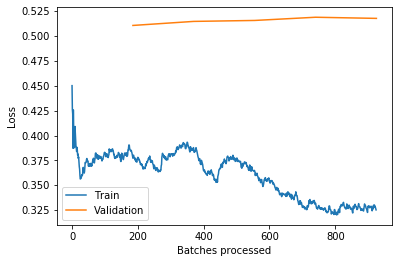

In [51]:
#learn.recorder.plot_losses()

In [52]:
#learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [53]:
#learn.load(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

### Larger size images

In [33]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/512'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/512'

In [34]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [35]:
data = (src.transform(tfms, size=512)
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [36]:
learn=learn.to_fp16()

In [37]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


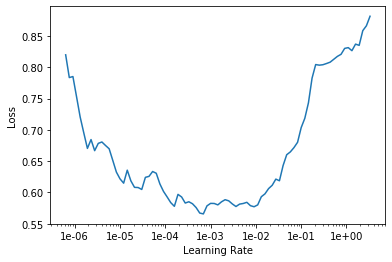

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
lr=1e-4

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.626684,0.541877,0.198050,02:39
1,0.596024,0.536499,0.193006,02:33
2,0.597701,0.535854,0.187962,02:34
3,0.544371,0.531352,0.190652,02:33
4,0.533703,0.528884,0.192670,02:33


In [41]:
learn.save(f'stage-1-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


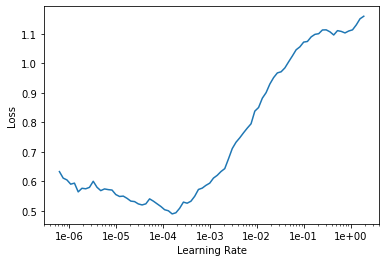

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.571177,0.510849,0.184264,03:46
1,0.553203,0.518029,0.185272,04:07
2,0.514422,0.518007,0.185272,04:06
3,0.478186,0.490322,0.181237,03:44
4,0.473367,0.488676,0.176866,03:44


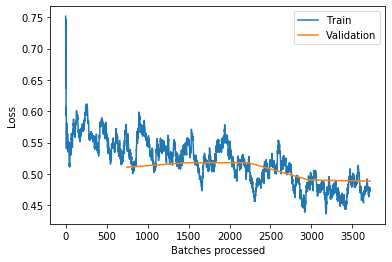

In [45]:
learn.recorder.plot_losses()

In [47]:
learn.save(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [48]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.463793,0.504715,0.181910,03:32
1,0.531575,0.511524,0.187290,03:55
2,0.492366,0.521952,0.192334,04:04
3,0.441700,0.518474,0.186617,04:01
4,0.444924,0.505126,0.187290,04:04


In [49]:
learn.load(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/512;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/512;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/512, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [50]:
#learn.export()

### inference

In [51]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [52]:
len(test_dataset)

7325

In [53]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}', test=test_dataset)

In [54]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [55]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [56]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [57]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [58]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [59]:
labels = np.argmax(preds, 1)

In [60]:
len(preds)

7325

In [61]:
preds[0].tolist()

[0.04976986348628998,
 0.9292306900024414,
 0.007029904518276453,
 0.009439458139240742,
 0.004530138336122036]

In [62]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [63]:
len(labels)

7325

In [64]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [65]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [66]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [67]:
test_predictions[0]

'healthy_metal'

In [68]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [69]:
 learn.data.test_ds.x.items

array([PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4d9168.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4ae922.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a48ca98.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a49c614.tif'), ...,
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a486800.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4c49fc.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a501f50.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4d27b4.tif')], dtype=object)

In [70]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [71]:
preds_list[0]

[0.04976986348628998,
 0.9292306900024414,
 0.007029904518276453,
 0.009439458139240742,
 0.004530138336122036]

In [72]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [73]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [74]:
df.head()

,id,pred
0,7a4d9168,"[0.04976986348628998, 0.9292306900024414, 0.00..."
1,7a4ae922,"[0.010492573492228985, 0.9206958413124084, 0.0..."
2,7a48ca98,"[0.01590052992105484, 0.16423913836479187, 0.0..."
3,7a49c614,"[0.011427822522819042, 0.7953259348869324, 0.0..."
4,7a4dd4f2,"[0.0036265249364078045, 0.9762927293777466, 0...."


In [75]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [76]:
pred_df.insert(loc=0, column='id', value=ids)

In [77]:
pred_df.columns = cols

In [78]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.049770,0.929231,0.007030,0.009439,0.004530
1,7a4ae922,0.010493,0.920696,0.010517,0.052909,0.005385
2,7a48ca98,0.015901,0.164239,0.026627,0.783768,0.009465
3,7a49c614,0.011428,0.795326,0.011362,0.176179,0.005705
4,7a4dd4f2,0.003627,0.976293,0.007304,0.005020,0.007757


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [79]:
pred_ids=pred_df['id'].values.tolist()

In [82]:
df_baseline = pd.read_csv(data_orig/f'submissions/mean_baseline.csv')

In [83]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [84]:
baseline_ids=df_baseline['id'].values.tolist()

In [85]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [86]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [87]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.049770,0.929231,0.007030,0.009439,0.004530,7a4d9168
1,7a4ae922,0.010493,0.920696,0.010517,0.052909,0.005385,7a4ae922
2,7a48ca98,0.015901,0.164239,0.026627,0.783768,0.009465,7a48ca98
3,7a49c614,0.011428,0.795326,0.011362,0.176179,0.005705,7a49c614
4,7a4dd4f2,0.003627,0.976293,0.007304,0.005020,0.007757,7a4dd4f2


In [88]:
pred_df=pred_df.sort_values('id_cat')

In [89]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.016962,0.909937,0.024551,0.039229,0.009321,7a4d630a
764,7a4bbbd6,0.004710,0.912983,0.010010,0.064491,0.007805,7a4bbbd6
1841,7a4ac744,0.025934,0.636182,0.011182,0.313565,0.013137,7a4ac744
3363,7a4881fa,0.012970,0.025070,0.022533,0.931085,0.008342,7a4881fa
133,7a4aa4a8,0.031928,0.391108,0.018027,0.547754,0.011184,7a4aa4a8


In [90]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [91]:
pred_df.to_csv(data_orig/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission 24: 0.4629


In [ ]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")